# Bayesian Optimization with Gaussian Processes

---

# Gaussian Basics

> $$X_i \sim \mathcal N \left( 0, 1\right)$$

To get different values for the mean and variance:

> $$Y_i \sim \mathcal N \left( \mu, \sigma^2\right)$$

>
> $$Y_i \sim \mu + \sigma \ \mathcal N \left( 0, 1\right)$$

So

> $$Y_i = \mu + \sigma X_i \sim \mathcal N \left( \mu, \sigma^2\right)$$

### More dimensions

We have
> $$\left[\begin{matrix}X_1\\
X_2\end{matrix}\right]_i 
\sim N \left(\left[\begin{matrix}0\\
0\end{matrix}\right],
\left[\begin{matrix}1&0\\
0&1\end{matrix}\right]\right)$$


We want
>$$\left[\begin{matrix}Y_1\\
Y_2\end{matrix}\right]_i 
\sim N \left(\left[\begin{matrix}\mu_1\\
\mu_2\end{matrix}\right],
\left[\begin{matrix}\Sigma_{11}&\Sigma_{12}\\
\Sigma_{21}&\Sigma_{22}\end{matrix}\right]\right)$$

* Sum to get the right means.

* Multiply by $L$ to get the covariance matrix $\mathbf \Sigma$ , where $L$ is one of the terms of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf \Sigma$ 
$$\left[\begin{matrix}Y_1\\
Y_2\end{matrix}\right]_i 
= \left[\begin{matrix}\mu_1\\
\mu_2\end{matrix}\right] + L \left[\begin{matrix}X_1\\
X_2\end{matrix}\right]_i $$

Where
> $$\mathbf \Sigma = LL^T$$

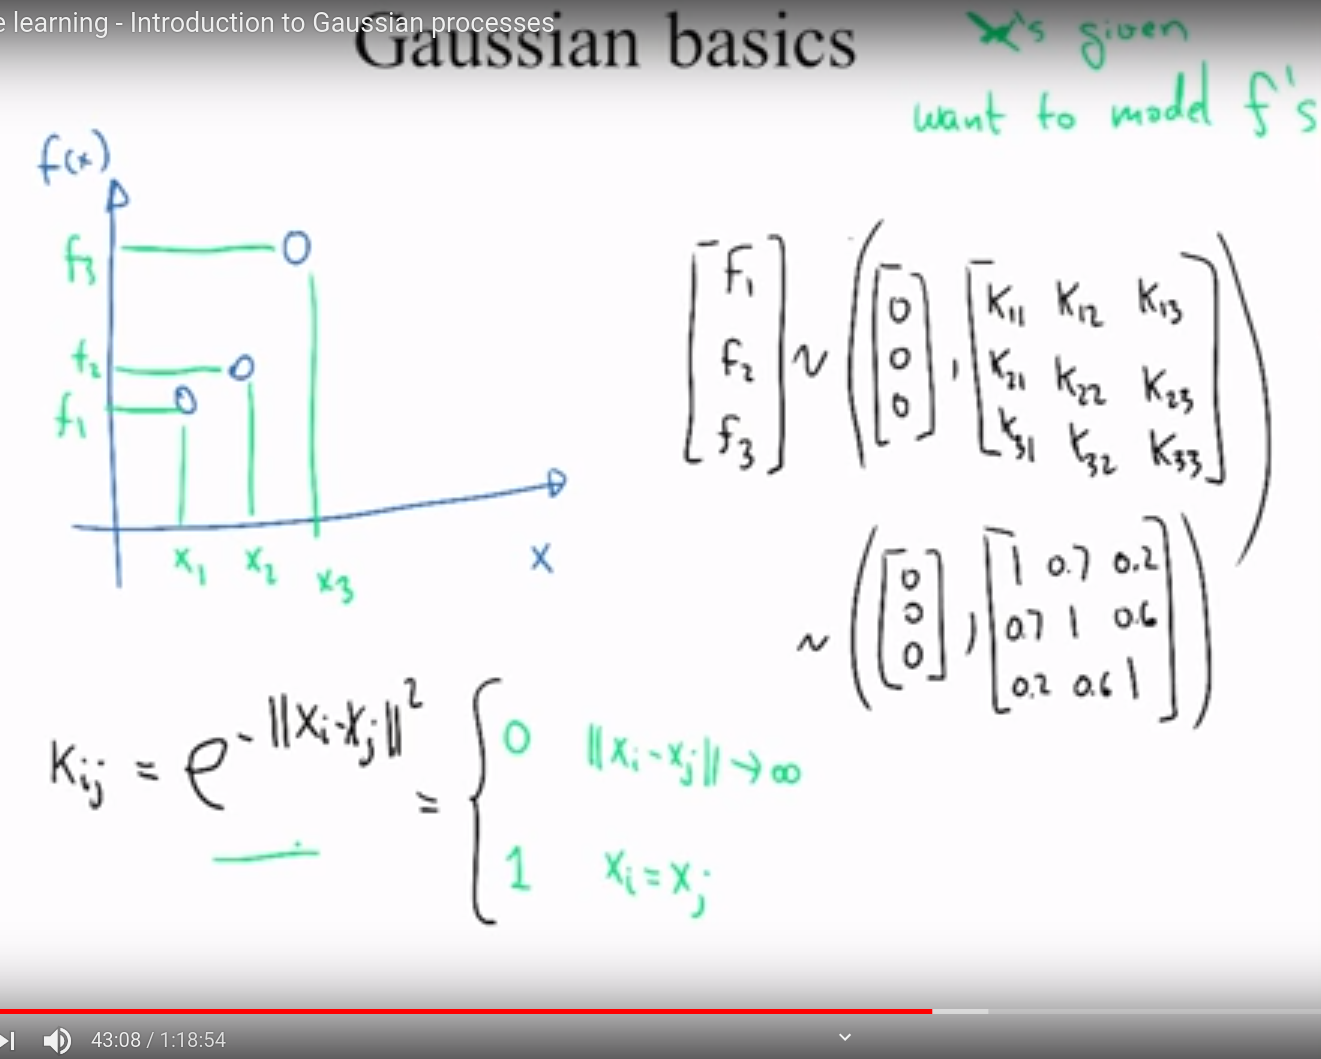

>If we construct a ***matrix of similarities*** $\mathbf K$ using some measure of distance between $X_i$ points
>
>and we use it as the ***covariance matrix*** $\mathbf \Sigma$ for constructing $ N(\mathbf 0, \mathbf K) \approx N(\mathbf 0, \mathbf \Sigma)$
>
>we will have a **model** that makes **good predictions** of the height $f_i$
>
> not only for the points used to construct $\mathbf K$
>
> BUT for ***any new point, or set of points*** $\mathbf X_{test}$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist

### Squared Exponential Kernel

> $$\large K_{ij} = e^{-||X_i - X_j||^2}$$

In [78]:
def sqexp_kernel(x1, x2):
    'Returns exp(-||x1,x2||**2) forall xi,xj'
    d = dist.cdist(x1, x2, 'sqeuclidean')
    K = np.exp(-d**2)
    return K

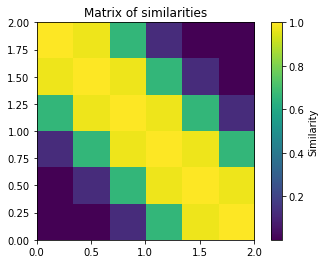

Input data X = 
[[0. ]
 [0.4]
 [0.8]
 [1.2]
 [1.6]
 [2. ]]
Matrix K = 
[[1.00  0.97  0.66  0.13  0.00  0.00]
 [0.97  1.00  0.97  0.66  0.13  0.00]
 [0.66  0.97  1.00  0.97  0.66  0.13]
 [0.13  0.66  0.97  1.00  0.97  0.66]
 [0.00  0.13  0.66  0.97  1.00  0.97]
 [0.00  0.00  0.13  0.66  0.97  1.00]]


In [110]:
X = np.linspace(0, 2, 6)[:, np.newaxis]

K = sqexp_kernel(X, X)
plt.imshow(K, extent=[0, 2, 0, 2])
plt.title('Matrix of similarities')
plt.colorbar().set_label("Similarity")
plt.show()
print("Input data X = \n{}".format(X))
print("Matrix K = \n{}".format(np.array2string(K, precision=2, separator="  ",
                                  formatter={'float_kind':lambda x: "%.2f" % x})))

In [141]:
'''Starting code from:
https://github.com/cottrell/ipynb/blob/894ee9409f71aeb477dc9b635f3d49bc48152028/ml/GP.ipynb
Possibly from Nando's files for this Homework3, lost in time.'''

class GP:
    """ (n, d)-array xtrain and an n-vector ytrain """
    def __init__(self, kernel, sigma=1.0):
        self.kernel = kernel
        self.sigma  = sigma
        self.predict = self.posterior
        self.fit = self.add_data
        
    def add_data(self, xtrain, ytrain):
        """ Append data, update mu and K """
        self.xtrain = xtrain # hstack(self.xtrain, xtrain)
        self.ytrain = ytrain # hstack(self.ytrain, ytrain)
        self.K  = self.kernel(self.xtrain, self.xtrain)
        K = self.K
        sigma = self.sigma
        I = np.eye(len(xtrain))
        # K + noise of y, where y = f(x)+noise
        self.Ky = K + sigma ** 2 * I
        
    def posterior(self, xtest):
        """ Compute mu_star, K_star, sigma_star """
        Ks  = self.kernel(self.xtrain, xtest)
        Kss = self.kernel(xtest, xtest)
        
        Kyinv = np.linalg.inv(self.Ky)
        KKyT  = np.dot(Ks.T, Kyinv)
        
        mu = np.dot(KKyT, self.ytrain)
        Ss = Kss - np.dot(KKyT, Ks) 
        return mu, Ss

In [112]:
def sqexp_kernel_adv(x1, x2, ell=.5, sf2=1.0):
    """ x1 and x2 of size (n, d) and (m, d) """
    d = dist.cdist(x1, x2, 'sqeuclidean')
    k = sf2 * np.exp(-0.5 * d / ell)
    return k

In [113]:
myGP = GP(sqexp_kernel, sigma=0.1)

In [114]:
m = 2
n = 1
X = np.random.normal(size=(m, n))
a = np.random.normal(size=n)
y = np.dot(X, a)


print("{}x{} random N(0,1) values".format(X.shape[0], X.shape[1]))
print("{} output values Xa".format(y.shape[0]))

2x1 random N(0,1) values
2 output values Xa


In [115]:
%matplotlib inline

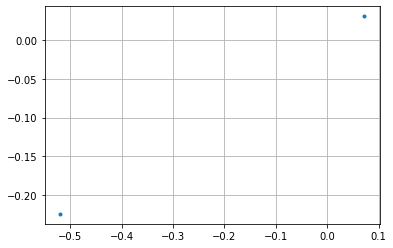

Points at:
P1: -0.5198, -0.2249
P2: 0.07214, 0.03121


In [116]:
plt.plot(X, y, '.')
plt.grid()
plt.show()

print("Points at:")
print("P1: {:.4}, {:.4}".format(X[0][0],y[0]))
print("P2: {:.4}, {:.4}".format(X[1][0],y[1]))


In [117]:
gp = GP(sqexp_kernel, sigma=0.05)
gp.add_data(X, y)

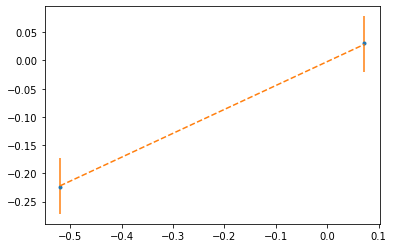

In [118]:
for i in range(X.shape[1]):
    x  = X[:,i]
    xx = X[:,i].copy()
    ia = xx.argsort()
    xx = np.atleast_2d(np.linspace(x.min(), x.max(), m)).T
    yy = np.atleast_2d(np.linspace(y.min(), y.max(), m)).T
    yp, s2 = gp.posterior(X)
    plt.plot(xx, y, '.')
    plt.errorbar(xx, yp, yerr=np.sqrt(np.diag(s2)), linestyle="--")
plt.show()

In [119]:
yp, s2 = gp.posterior(X)
print("Mean posterior: ", yp)
print("Variance: ", s2)

Mean posterior:  [-0.22201143  0.02862368]
Variance:  [[2.47187047e-03 2.48173182e-05]
 [2.48173182e-05 2.47187047e-03]]


In [134]:
n_test = 100
Xtest = np.linspace(-5, 5, n_test).reshape(-1,1)

In [135]:
print("Points at:")
print("P1: {:.4}, {:.4}".format(X[0][0],y[0]))
print("P2: {:.4}, {:.4}".format(X[1][0],y[1]))

Points at:
P1: -0.5198, -0.2249
P2: 0.07214, 0.03121


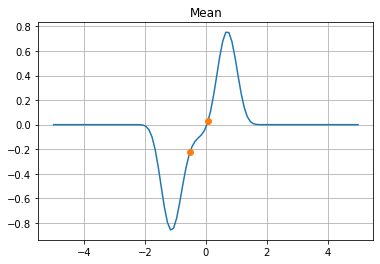

In [136]:
yp, s2 = gp.posterior(Xtest)
plt.plot(Xtest, yp)
plt.plot(X, y, marker="o",linestyle=" ")
plt.title("Mean")
plt.grid()
plt.show()

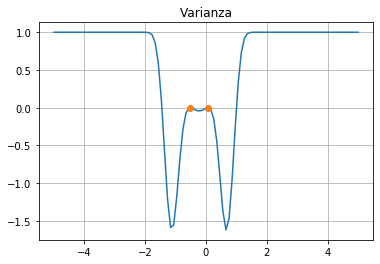

In [140]:
plt.plot(Xtest, np.diag(s2))
plt.grid()
plt.plot(X, np.zeros(X.size), marker="o", linestyle=" ")
plt.title("Varianza")
plt.show()

In [138]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
n_samples = 1
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_test, n_samples)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')
pl.show()

NameError: name 'K_' is not defined